In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
from sets import Set
import rcca_modified as rcca
#reload(rcca)

from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from unils_cca import BuildMatrixA, printMatrix, print_q_val_hist, zscore, plot_zscore, BuildFeatureVector,\
train_test_2D, build_distance_for_node,  get_features, BuildMatrix_w_ambig, set_diag_to_zero, binarize, binarize_w_unlabeled

/users/mtaranov/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: the sets module is deprecated


In [2]:
InteractionsFileCaptureC='/srv/scratch/mtaranov/CaptureC_ChicagoCalls/CaptureC_SC_bait-bait.bed.gz'
#InteractionsFileCaptureC='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/D0_D2D8_merge_BaitToBait_intra.bed.gz'
PromoterFile='/srv/scratch/mtaranov/HindIII/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
DATADIR='/users/mtaranov/CCA_model/data/'
DATADIR_CaptureC = DATADIR+'CaptureC/'
DATADIR_kernels = DATADIR+'CaptureC_kernels/'
DATADIR_nodes = DATADIR+'nodes/'
DATADIR_features = DATADIR+'features/'
features_dir='/srv/scratch/mtaranov/peaks_at_promoters/output_thres5_max/'

In [3]:
Capture_wAmbig = np.load(DATADIR_CaptureC+'CaptureC_wAmbig_'+'chr1'+'.npy')
kernel_Capture = set_diag_to_zero(np.load(DATADIR_kernels+'kernel_CaptureC_'+'chr1'+'.npy'))

46.6549268544
(2272, 2272)
Limit: 46.6549268544


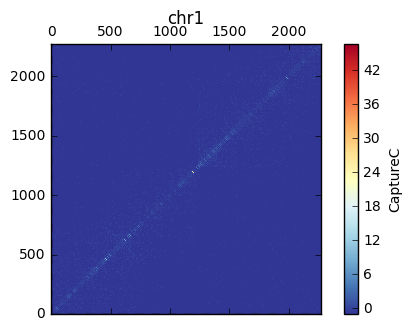

In [4]:
printMatrix(Capture_wAmbig, 'CaptureC', 1, 1, 'chr1')

0.380533635889
(2272, 2272)
Limit: 0.380533635889


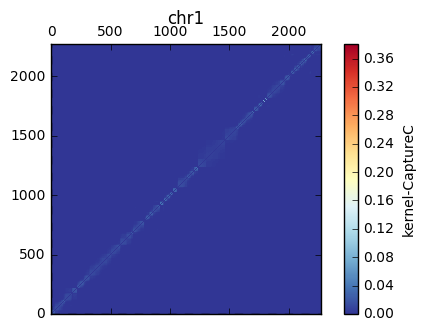

In [5]:
printMatrix(kernel_Capture, 'kernel-CaptureC', 1, 1, 'chr1')

1.0
(2272, 2272)
Limit: 1.0


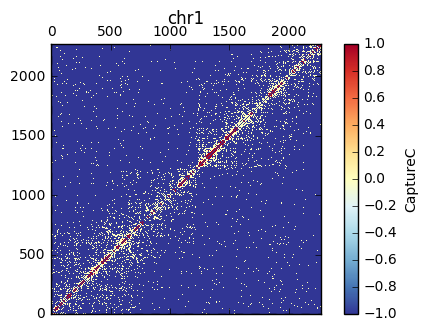

In [6]:
printMatrix(binarize_w_unlabeled(Capture_wAmbig, 0), 'CaptureC', 1, 1, 'chr1')

1.0
(2272, 2272)
Limit: 1.0


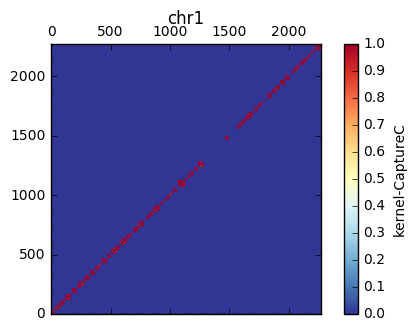

In [7]:
printMatrix(binarize_w_unlabeled(kernel_Capture, 0.01), 'kernel-CaptureC', 1, 1, 'chr1')

In [8]:
Capture_wAmbig_1d = Capture_wAmbig.ravel()
kernel_Capture_1d = kernel_Capture.ravel()

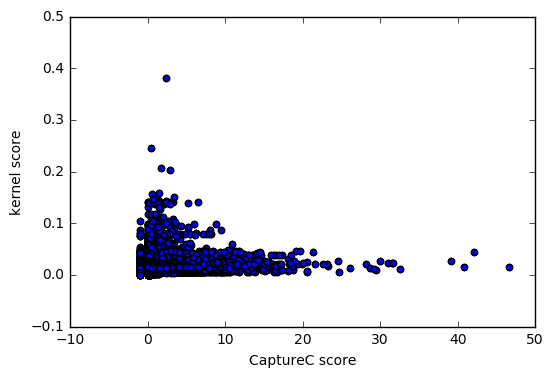

In [9]:
plt.scatter(Capture_wAmbig_1d , kernel_Capture_1d)
plt.xlabel('CaptureC score')
plt.ylabel('kernel score')

In [10]:
thres_CaptureC = 10
thres_kernel = 0.075
print 'CaptureC_thres=', thres_CaptureC, 'kernel_CaptureC_thres=', thres_kernel
Capture_wAmbig_1d_pos_indx = Set(np.where(Capture_wAmbig_1d > thres_CaptureC)[0])
kernel_Capture_1d_pos_indx = Set(np.where(kernel_Capture_1d >thres_kernel)[0])
print 'CaptureC_pos=', len(Capture_wAmbig_1d_pos_indx), 'kernel_pos=', len(kernel_Capture_1d_pos_indx)
common_pos = Capture_wAmbig_1d_pos_indx & kernel_Capture_1d_pos_indx 
print 'common_pos=', len(common_pos)

CaptureC_thres= 10 kernel_CaptureC_thres= 0.075
CaptureC_pos= 442 kernel_pos= 478
common_pos= 0


In [18]:
thres_CaptureC = 0
thres_kernel = 0.05
print 'CaptureC_thres=', thres_CaptureC, 'kernel_CaptureC_thres=', thres_kernel
Capture_wAmbig_1d_pos_indx = Set(np.where(Capture_wAmbig_1d > thres_CaptureC)[0])
Capture_wAmbig_1d_top_pos_indx = Set(np.where(Capture_wAmbig_1d > 5)[0])
kernel_Capture_1d_pos_indx = Set(np.where(kernel_Capture_1d >thres_kernel)[0])
print 'CaptureC_pos=', len(Capture_wAmbig_1d_pos_indx), 'kernel_pos=', len(kernel_Capture_1d_pos_indx)
common_pos = Capture_wAmbig_1d_pos_indx & kernel_Capture_1d_pos_indx 
print 'common_pos=', len(common_pos)
print 'CaptureC_top_pos=', len(Capture_wAmbig_1d_top_pos_indx)
common_top_pos = Capture_wAmbig_1d_top_pos_indx & kernel_Capture_1d_pos_indx 
print 'common_top_pos=', len(common_top_pos)

CaptureC_thres= 0 kernel_CaptureC_thres= 0.05
CaptureC_pos= 44402 kernel_pos= 912
common_pos= 736
CaptureC_top_pos= 2304
common_top_pos= 42


out of 912 pos: 
736 pos
14 ambig
162 neg

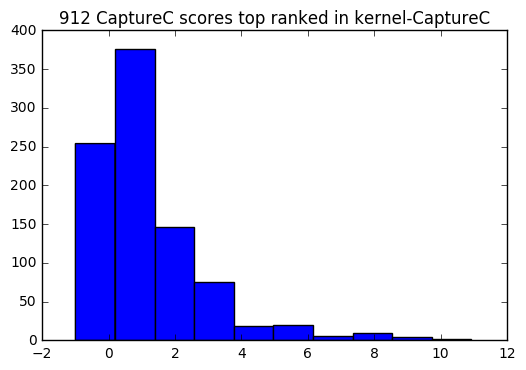

In [12]:
plt.hist(Capture_wAmbig_1d[list(kernel_Capture_1d_pos_indx)])
plt.title('912 CaptureC scores top ranked in kernel-CaptureC')

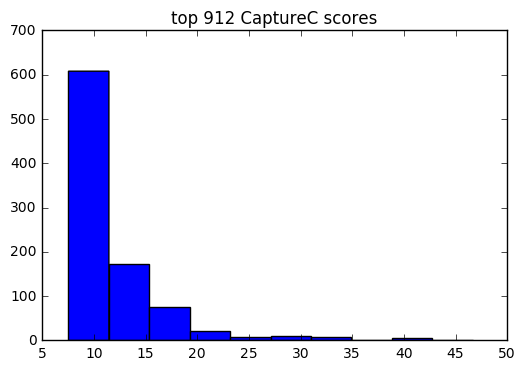

In [13]:
plt.hist(np.sort(Capture_wAmbig_1d)[::-1][:912])
plt.title('top 912 CaptureC scores')

In [21]:
thres_CaptureC = 0
thres_kernel = 0.03
print 'CaptureC_thres=', thres_CaptureC, 'kernel_CaptureC_thres=', thres_kernel
Capture_wAmbig_1d_pos_indx = Set(np.where(Capture_wAmbig_1d > thres_CaptureC)[0])
Capture_wAmbig_1d_top_pos_indx = Set(np.where(Capture_wAmbig_1d > 5)[0])
kernel_Capture_1d_pos_indx = Set(np.where(kernel_Capture_1d >thres_kernel)[0])
print 'CaptureC_pos=', len(Capture_wAmbig_1d_pos_indx), 'kernel_pos=', len(kernel_Capture_1d_pos_indx)
common_pos = Capture_wAmbig_1d_pos_indx & kernel_Capture_1d_pos_indx 
print 'common_pos=', len(common_pos)
print 'CaptureC_top_pos=', len(Capture_wAmbig_1d_top_pos_indx)
common_top_pos = Capture_wAmbig_1d_top_pos_indx & kernel_Capture_1d_pos_indx 
print 'common_top_pos=', len(common_top_pos)

CaptureC_thres= 0 kernel_CaptureC_thres= 0.03
CaptureC_pos= 44402 kernel_pos= 5010
common_pos= 3716
CaptureC_top_pos= 2304
common_top_pos= 308


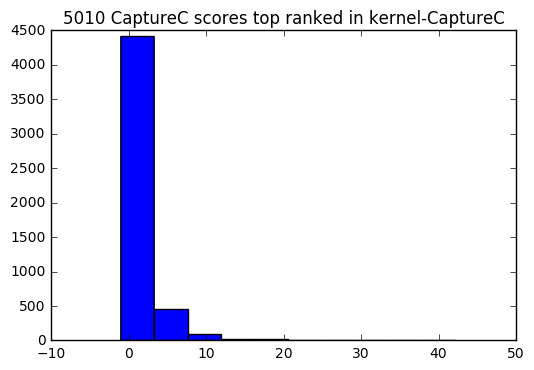

In [22]:
plt.hist(Capture_wAmbig_1d[list(kernel_Capture_1d_pos_indx)])
plt.title('5010 CaptureC scores top ranked in kernel-CaptureC')